# Identify family interactions based on if they shared the same objects

In [1]:
%matplotlib inline

import os, re, glob, datetime, json
from os.path import join as opj
import pandas as pd
import numpy as np
import scipy.stats
from tqdm import tqdm
from datetime import datetime

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout

## load data

In [2]:
baseDir = '../data/publicMapChangeData/bigserver2.onehouronelife.com/'

In [3]:
timestamp = 1578441147

In [4]:
data = pd.read_csv(baseDir + str(timestamp) + 'time_mapLog.txt')
data.head()

,startTime: 1578441146.79
0,0.00 -1689 406 0 2540914
1,0.03 -1876 662 0 -1
2,0.03 -1876 662 59 2540929
3,0.13 -2632 -841 0 2540918
4,0.16 -2628 -828 72 2540844


In [5]:
data[['time','locX','locY','obj','playerID']] = data[data.columns[0]].str.split(" ",expand=True)
data = data[['time','locX','locY','obj','playerID']]
data.head(n = 10)

,time,locX,locY,obj,playerID
0,0.00,-1689,406,0,2540914
1,0.03,-1876,662,0,-1
2,0.03,-1876,662,59,2540929
3,0.13,-2632,-841,0,2540918
4,0.16,-2628,-828,72,2540844
5,0.43,-1760,-1100,0,-1
6,0.43,-1760,-1100,107,2540917
7,0.45,-1215,291,0,2540825
8,0.48,5400229,8639,30u4,2540939
9,0.50,-1076,84,264,2540932


## Approach 1: focus on location and family

find family from output data

In [8]:
fam= pd.read_csv('../2_demographics/outputs/family_playerID.tsv', sep = '\t', index_col = 0)
fam.head(n=10)

/Users/dengwenning/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,playerID,family
0,3080084,time-1592284232_eve-3080067_name-PICKLE
1,3080114,time-1592284232_eve-3080067_name-PICKLE
2,3080111,time-1592284232_eve-3080067_name-PICKLE
3,3080108,time-1592284232_eve-3080067_name-PICKLE
4,3080104,time-1592284232_eve-3080067_name-PICKLE
5,3080130,time-1592284232_eve-3080067_name-PICKLE
6,3080122,time-1592284232_eve-3080067_name-PICKLE
7,3080117,time-1592284232_eve-3080067_name-PICKLE
8,3080067,time-1592284232_eve-3080067_name-PICKLE
9,3080044,time-1592283401_eve-3080044_name-KORE


In [9]:
def find_fam(playerId):
    playerId = int(playerId)
    family = fam.loc[fam['playerID'] == playerId,'family'].tolist()

    if len(family):    
        fam_name = family[0].split('-')[-1]
    else:
        fam_name = fam_name = "UnKnown"
    
    return fam_name

check if every player has a last name (No!) and find the number of players in a family

In [83]:
fam_dict = {}
for i in data['playerID'].unique():
    i = int(i)
    if (i != -1) and (i != 0):
        family = fam.query('playerID == @i')['family'].values
        if len(family):
            family_name = family[0].split('-')[-1]
            print(i, family_name)
            if family_name in fam_dict.keys():
                fam_dict[family_name] = fam_dict[family_name]+1
            else:
                fam_dict[family_name] = 1
        else:
            print(i)
        

2540914
2540929
2540918 STRONG
2540844 STRONG
2540917 GONGLOFF
2540825 HELL
2540939
2540932 HELL
2540965 HEAVEN
2540838 HELL
2540963 VIKER
2540933 STRONG
2540913 HEAVEN
2540959 STRONG
2540795 HEAVEN
2540891 VIKER
2540880 HELL
2540951 STRONG
2540981
2540897 THE
2540966 HELL
2540831 HELL
2540814 HEAVEN
2540977 HELL
2540915 GONGLOFF
2540836 HEAVEN
2540877 HELL
2540786 THE
2540799 HEAVEN
2540837 HEAVEN
2540784 THE
2540953 HELL
2540846 HEAVEN
2540964 GONGLOFF
2540910 HEAVEN
2540974 STRONG
2540885 STRONG
2540894 HELL
2540969 HELL
2540934 GONGLOFF
2540895 HEAVEN
2540907 HEAVEN
2540930 GONGLOFF
2540912 HELL
2540813 HELL
2540928 HEAVEN
2540971 HELL
2540947 STRONG
2540800 HELL
2540785 GODDEN
2540898 HEAVEN
2540985
2540979 GONGLOFF
2540936 HEAVEN
2540946 HELL
2540876 THE
2540958 HELL
2540812 STRONG
2540976 HELL
2540842 GODDEN
2540864 HELL
2540967 GONGLOFF
2540960 HELL
2540945 HEAVEN
2540978 HELL
2540957 HELL
2540855 GONGLOFF
2540909 HEAVEN
2540803 HELL
2540991
2540993
2540994
2540995
2540792 HELL

2541750 KARSCH
2541759
2541762
2541754 AN
2541753 AN
2541764
2541767 PUCCI
2541748 HELL
2541757 HELL
2541760 HEAVEN
2541761 DOBBIE
2541765 HEAVEN
2541769 LOLA
2541766 HEAVEN
2541768 LOLA
2541770 HELL
2541778
2541774 AN
2541773 AN
2541775 HEAVEN
2541777 HELL
2541783 GAY
2541784 GAYA
2541779 AN
2541787 AN
2541780 HEAVEN
2541792
2541781 HEAVEN
2541782 DOBBIE
2541785 HEAVEN
2541796 DOBBIE
2541786 HEAVEN
2541788 HELL
2541794
2541789 HELL
2541791 HELL
2541776 HELL
2541797 HEAVEN
2541801 HELL
2541804
2541807
2541798 HELL
2541802 HEAVEN
2541812 HELL
2541803 DOBBIE
2541813
2541806 AN
2541811 LOLA
2541810 HEAVEN
2541815 HEAVEN
2541814 HELL
2541816 AN
2541818 DOBBIE
2541819 HEAVEN
2541817 DOBBIE
2541823
2541824
2541826
2541820 AN
2541821 AN
2541831
2541822 LOLA
2541840
2541839 AN
2541834 HELL
2541844
2541846
2541836 HELL
2541837 AN
2541838 HELL
2541842 HELL
2541849
2541841 DOBBIE
2541843 HELL
2541845 HEAVEN
2541847 HEAVEN
2541854 HELL
2541850 LOLA
2541859
2541851 LOLA
2541853 AN
2541855 HEAVEN
25

2542631
2542629
2542635
2542618 LOLA
2542637
2542639
2542620 BYTHEWAY
2542640
2542643
2542624 LOLA
2542626 LOLA
2542614 LOLA
2542632 BYTHEWAY
2542634 DOSHI
2542636 LOLA
2542648
2542642 LOLA
2542647 BYTHEWAY
2542496 LOLA
2542652 LOLA
2542653 DOSHI
2542660
2542665
2542666
2542667
2542654 DOBBIE
2542658 BYTHEWAY
2542663
2542661 DOBBIE
2542668 LOLA
2542673 BYTHEWAY
2542675 LOLA
2542674 LOLA
2542676 LOLA
2542679
2542677 LOLA
2542672 PIGMAN
2542678 BYTHEWAY
2542683 HEAVEN
2542680 HEAVEN
2542681 LOLA
2542687
2542690
2542684 DOSHI
2542682 LOLA
2542686 LOLA
2542689 PIGMAN
2542696
2542576 LOLA
2542699
2542691 LOLA
2542694 HEAVEN
2542695 PIGMAN
2542703
2542688 HEAVEN
2542700 BYTHEWAY
2542697 DOSHI
2542701 LOLA
2542702 LOLA
2542708
2542709
2542704 DOSHI
2542710
2542705 BYTHEWAY
2542706 BYTHEWAY
2542714 BYTHEWAY
2542721
2542723
2542725
2542726
2542728
2542707 BYTHEWAY
2542727
2542729
2542730
2542733
2542735
2542737
2542717
2542734 BYTHEWAY
2542743
2542712 LOLA
2542711 LOLA
2542716 HEAVEN
2542718 LO

2543471 HEAVEN
2543473
2543478 HEAVEN
2543480
2543470 LOLA
2543477 LOLA
2543483 HEAVEN
2543484 HEAVEN
2543479 HEAVEN
2543485
2543486 LOLA
2543491
2543488
2543487 YESAYAN
2543489
2543490 HEAVEN
2543492 HEAVEN
2543495
2543493
2543496 YESAYAN
2543498 BUTT
2543505
2543497 HEAVEN
2543502 HEAVEN
2543500
2543501 HEAVEN
2543503 HEAVEN
2543499 BUTT
2543506
2543512
2543508 LOLA
2543507
2543510 BUTT
2543511 YESAYAN
2543513 YESAYAN
2543514 HEAVEN
2543515 HEAVEN
2543452
2543516 BUTT
2543517 YESAYAN
2543518 HEAVEN
2543521
2543524
2543519 YESAYAN
2543522
2543525 BUTT
2543523 YESAYAN
2543526 HEAVEN
2543531
2543534
2543529 YESAYAN
2543528
2543527
2543532 BUTT
2543533
2543530 HEAVEN
2543535 LOLA
2543539
2543540 HEAVEN
2543542 HEAVEN
2543541 BUTT
2543543 YESAYAN
2543550 YESAYAN
2543545 HEAVEN
2543544
2543549 YESAYAN
2543546 YESAYAN
2543547
2543554
2543553
2543551 LOLA
2543555 YESAYAN
2543556 YESAYAN
2543557 HEAVEN
2543558 YESAYAN
2543559 HEAVEN
2543561
2543563
2543564
2543565 HEAVEN
2543567 BUTT
2543568 

2544367
2544355
2544361 KILAR
2544370
2544362 WOLF
2544356 MENSINK
2544363 HEAVEN
2544365 HELL
2544364
2544366
2544374
2544368 WOLF
2544375
2544376
2544343
2544369
2544371 DOBBIE
2544372
2544383
2544377 WOLF
2544379
2544384 KILAR
2544388
2544380
2544390
2544393
2544391 HEAVEN
2544395
2544373 HEAVEN
2544381
2544398 DOBBIE
2544386
2544389 DOBBIE
2544394 KILAR
2544392 KILAR
2544399
2544402 HEAVEN
2544401 WOLF
2544403 HEAVEN
2544404 KILAR
2544385
2544405 WOLF
2544411
2544414
2544406
2544408
2544420
2544419
2544409
2544410
2544412
2544413 MENSINK
2544416
2544417 IDING
2544415 HEAVEN
2544421
2544423
2544418 HEAVEN
2544425
2544424
2544427 KILAR
2544432
2544422 KILAR
2544429
2544439
2544440
2544433 DOBBIE
2544428 HEAVEN
2544443
2544431
2544435 HEAVEN
2544436 KILAR
2544434 WOLF
2544437 HELL
2544455 KILAR
2544444
2544448 KILAR
2544451 HEAVEN
2544450 HELL
2544458
2544445 WOLF
2544454 MENSINK
2544449 DOBBIE
2544457 WOLF
2544467
2544469
2544459
2544471
2544475
2544460 HEAVEN
2544478
2544473 KILAR
2

## record connection in a dataframe

In [12]:
data['time'] = data['time'].astype(float)

Sort by location and time

In [69]:
data.query('(locX == "-385") and (locY == "-206")')

,time,locX,locY,obj,playerID
214687,6922.81,-385,-206,0,2541399
215428,6971.02,-385,-206,292,2541439
215856,7001.63,-385,-206,0,-1
215857,7001.63,-385,-206,356,2541415
215868,7002.30,-385,-206,0,-1
215869,7002.30,-385,-206,292,2541415
215937,7006.52,-385,-206,0,-1
215938,7006.52,-385,-206,356,2541415
216093,7015.37,-385,-206,0,2541415


In [70]:
parsed = data.sort_values(by = ['locX','locY','time'])
# parsed = parsed.iloc[0:50]
parsed.head()

,time,locX,locY,obj,playerID
233168,7568.64,-1,-259,467,2541439
233264,7573.26,-1,-259,0,2541439
233288,7574.74,-1,-259,467,2541439
233324,7577.15,-1,-259,0,2541439
232421,7520.71,-1,-281,391u0,2541277


tag previous player and object at this location

In [71]:
parsed['same_loc'] = parsed.locY.eq(parsed.locY.shift())

In [72]:
parsed['all_previous_obj'] = parsed.obj.shift()
parsed['previous_obj'] = parsed[parsed['same_loc']==True]['all_previous_obj']
parsed['all_previous_playerID'] = parsed.playerID.shift()
parsed['previous_playerID'] = parsed[parsed['same_loc']==True]['all_previous_playerID']

In [73]:
parsed = parsed[['time','locX','locY','obj','playerID','previous_obj','previous_playerID']]
parsed.head(n = 10)

,time,locX,locY,obj,playerID,previous_obj,previous_playerID
233168,7568.64,-1,-259,467,2541439,NaN,NaN
233264,7573.26,-1,-259,0,2541439,467,2541439
233288,7574.74,-1,-259,467,2541439,0,2541439
233324,7577.15,-1,-259,0,2541439,467,2541439
232421,7520.71,-1,-281,391u0,2541277,NaN,NaN
245626,8100.18,-1,-281,1135,2541517,391u0,2541277
246070,8143.38,-1,-282,391u0,2541517,NaN,NaN
246389,8165.40,-10,-278,1112u2,2541517,NaN,NaN
246401,8165.97,-10,-278,1112u1,2541517,1112u2,2541517
246424,8167.16,-10,-278,1112u0,2541517,1112u1,2541517


take data where an object at a location was changed by a different player

In [74]:
parsednew = parsed.loc[(parsed.obj != parsed.previous_obj) & (parsed.previous_obj != 0) \
                       & (parsed.previous_playerID != "-1") & (parsed.playerID != parsed.previous_playerID)\
                      & (parsed.playerID != "-1")].dropna()
parsednew = parsednew.sort_values(by = ['time'])

In [75]:
parsednew.head(n = 10)

,time,locX,locY,obj,playerID,previous_obj,previous_playerID
101,7.02,-1944,-268,2888,2540910,578,2540836
144,10.60,-1074,83,236,2540838,0,2540932
330,25.26,-1680,402,0,2540799,484,2540914
357,26.78,-1361,3,1135,2540912,391u0,2540784
376,28.17,-1680,402,183,2540914,0,2540799
395,29.18,-1680,403,0,2540914,484,2540799
519,38.73,-1963,-258,292,2540913,1605u0,2540895
523,38.80,-1943,-266,0,2540836,191,2540910
550,41.14,-1960,-260,1603u1,2540913,0,2540895
551,41.19,-1964,-281,0,2540898,1099,2540795


count the number of interactions between players (defined as two players interacted with the same object)

In [182]:
# sorteddf[['playerID','previous_playerID']]=np.sort(sorteddf[['playerID','previous_playerID']],1)
grouped = parsednew.groupby(['playerID','previous_playerID'])['time'].count().to_frame().reset_index()

In [81]:
parsednew.query('(playerID == "2541415")')

,time,locX,locY,obj,playerID,previous_obj,previous_playerID
203679,6319.03,-493,-392,0,2541415,292,2541340
203765,6325.32,-493,-392,0,2541415,40,2541399
205295,6443.64,-472,-393,0,2541415,292,2541340
206404,6520.13,-413,-403,30u3,2541415,30u4,2541399
206469,6524.62,-413,-403,30u1,2541415,30u2,2541399
207424,6593.40,-324,-404,0,2541415,39,2541399
214404,6904.38,-407,-226,30u2,2541415,30u3,2541399
215063,6947.54,-399,-199,0,2541415,356,2541277
216006,7010.54,-388,-205,292,2541415,0,2541399
219622,7061.20,-402,-202,135,2541415,3051,2541399


tag family names

In [183]:
grouped['player_fam'] = grouped['playerID'].map(find_fam)
grouped['previous_player_fam'] = grouped['previous_playerID'].map(find_fam)

In [184]:
grouped.head(n=10)

,playerID,previous_playerID,time,player_fam,previous_player_fam
0,2540785,2540799,1,GODDEN,HEAVEN
1,2540786,2540784,2,THE,THE
2,2540792,2540953,2,HELL,HELL
3,2540795,2540837,2,HEAVEN,HEAVEN
4,2540795,2540898,1,HEAVEN,HEAVEN
5,2540795,2540913,2,HEAVEN,HEAVEN
6,2540799,2540842,1,HEAVEN,GODDEN
7,2540799,2540914,12,HEAVEN,UnKnown
8,2540799,2540989,2,HEAVEN,UnKnown
9,2540800,2540825,2,HELL,HELL


plot player interactions

In [ ]:
sorteddf = parsednew.copy()
sorteddf[['playerID','previous_playerID']]=np.sort(sorteddf[['playerID','previous_playerID']],1)
sortednew = sorteddf.groupby(['playerID','previous_playerID'])['time'].count().to_frame().reset_index()

In [420]:
unique_fams = list(set(np.append(sortednew.player_fam.unique(), sortednew.previous_player_fam.unique())))
colors = {}
for i in unique_fams:
    colors[i] = list(np.random.choice(range(256), size=3)/256)

In [421]:
G = nx.from_pandas_edgelist(sortednew, 'playerID', 'previous_playerID') 
nodes = G.nodes()
color = [colors[find_fam(n)] for n in nodes] ##assign colors to nodes based on family

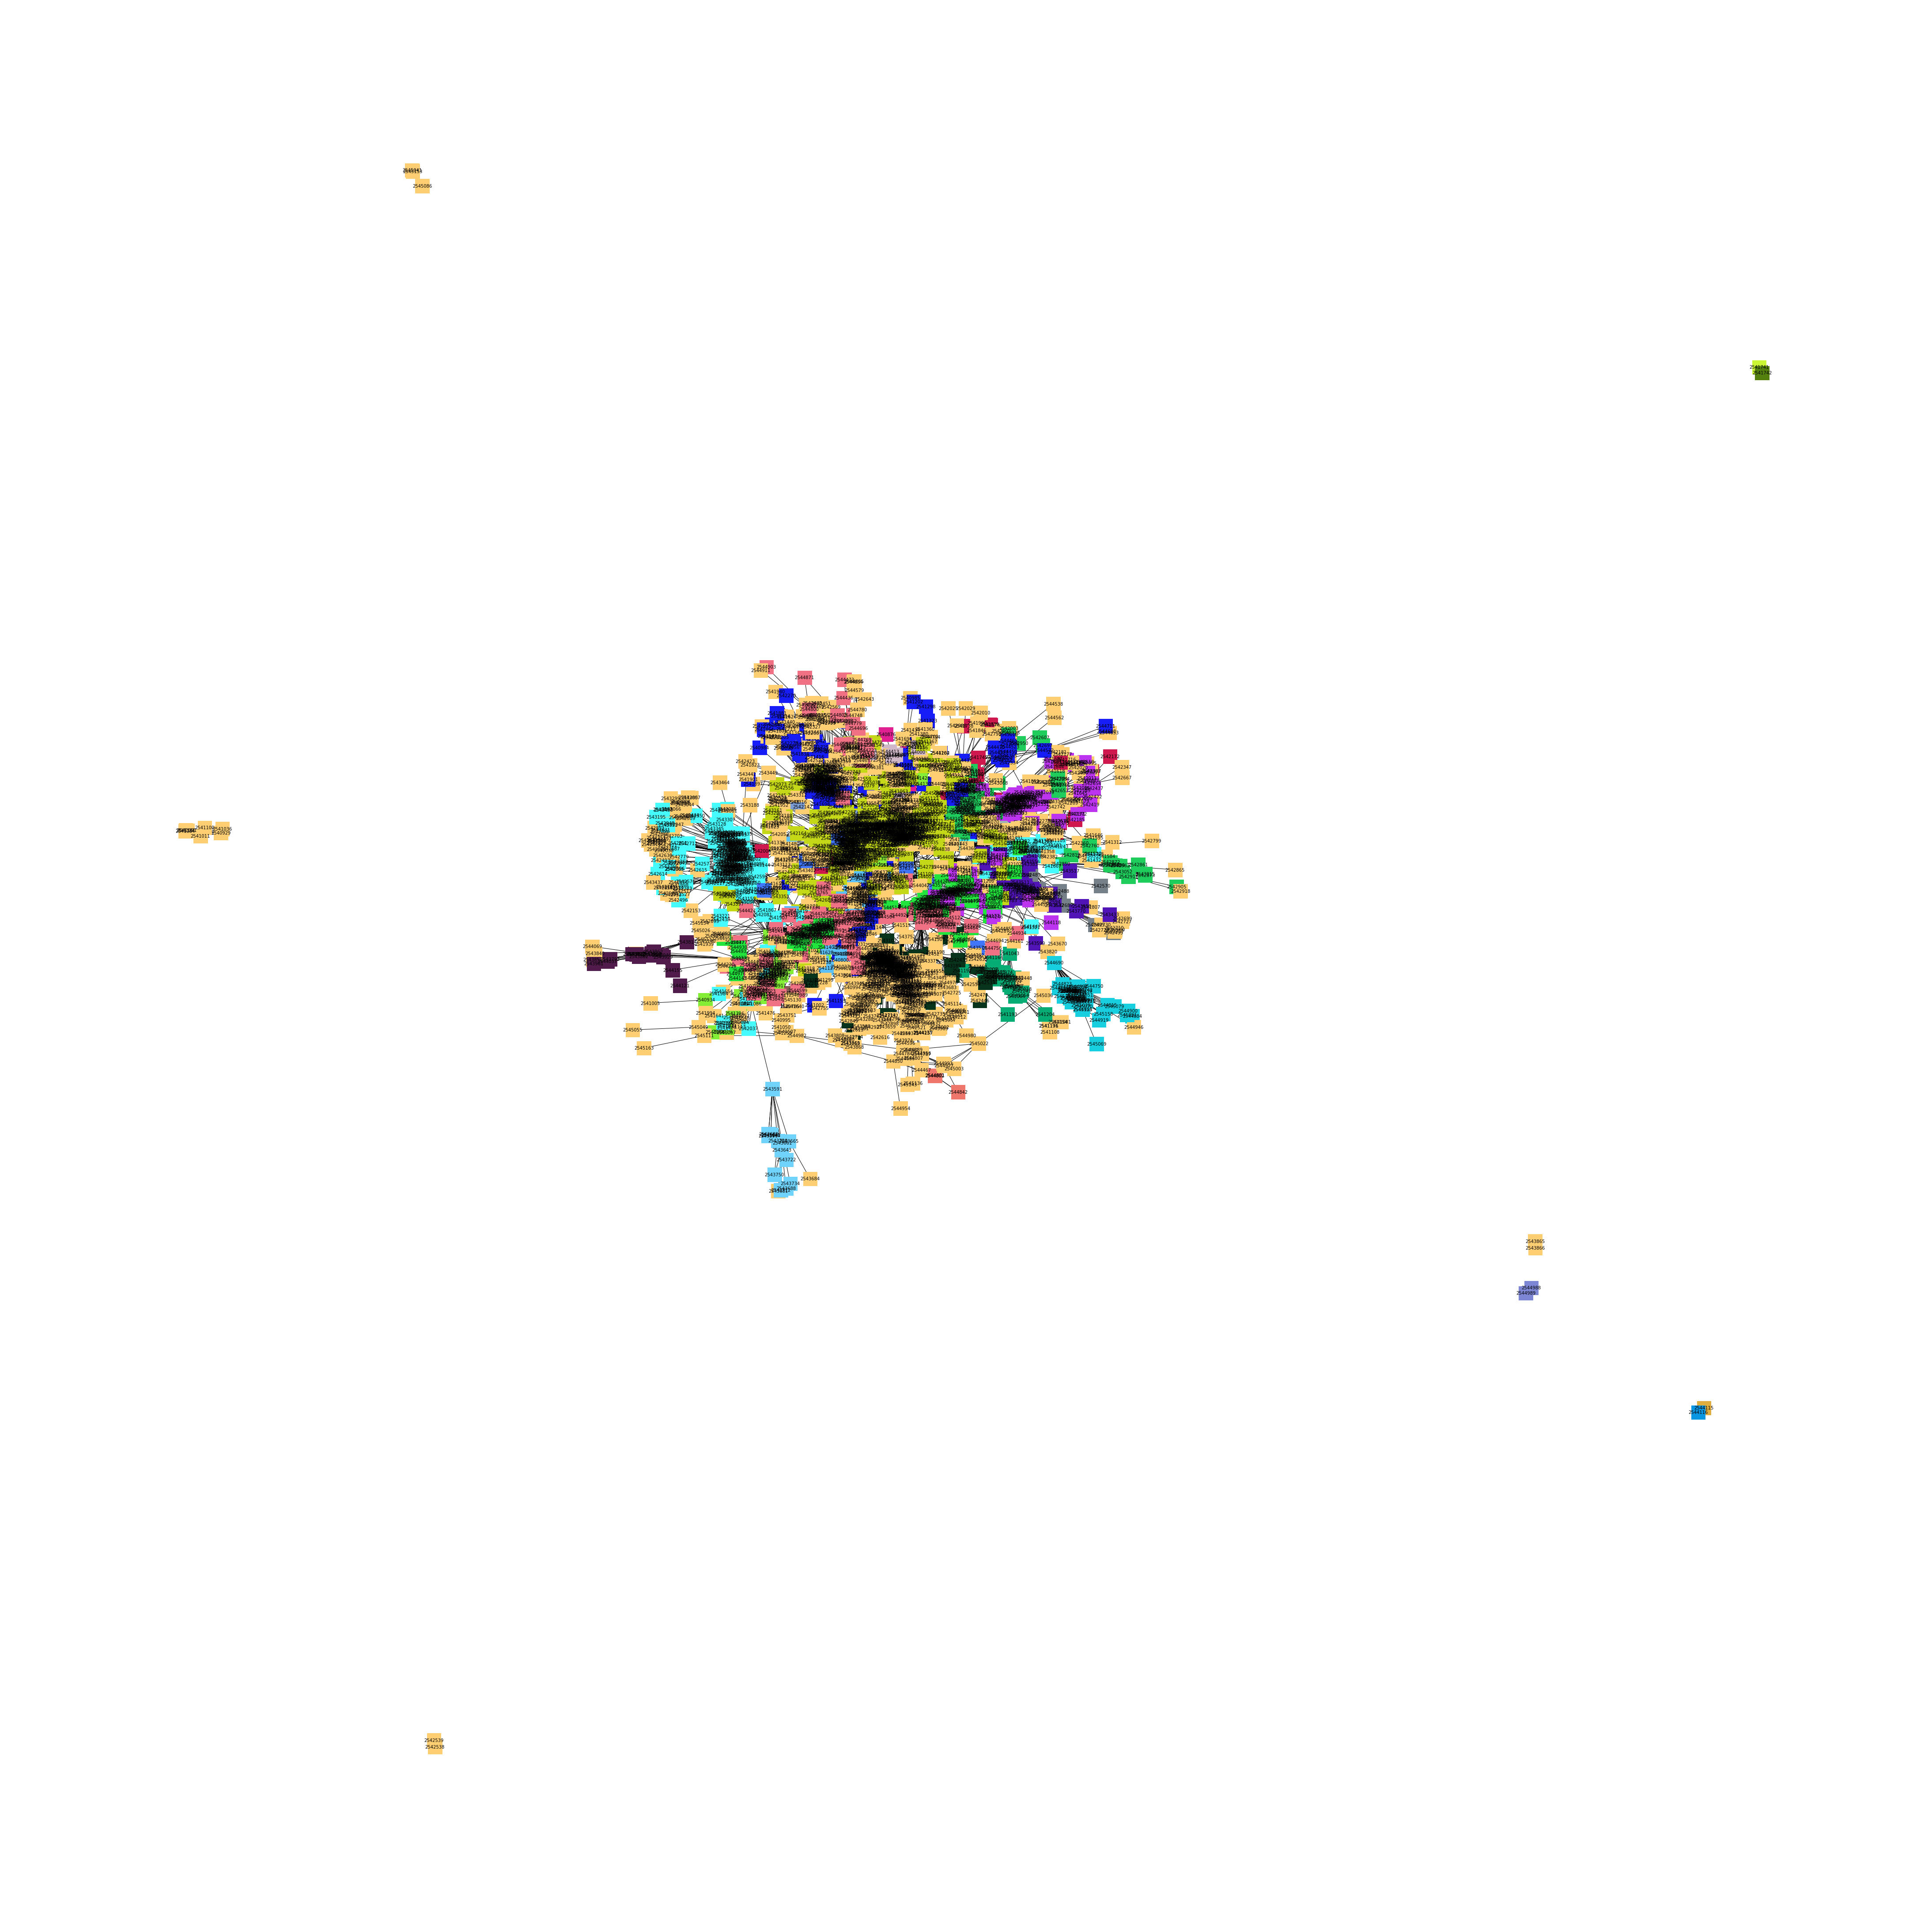

In [431]:
plt.figure(figsize=(60,60))
pos = nx.spring_layout(G, k=0.5/np.sqrt(len(nodes)), iterations=20) ##make nodes further apart
nx.draw(G, pos = pos, with_labels= True, node_shape='s', node_color = color, node_size=1000, font_size=10)
# plt.savefig('family.png', dpi = 100)

plot interactions by family

In [185]:
# sortednew = grouped.copy()
# sortednew[['player_fam','previous_player_fam']]=np.sort(sortednew[['player_fam','previous_player_fam']],1)
fam_df = grouped.groupby(['player_fam','previous_player_fam'])['time'].count().to_frame().reset_index()

In [186]:
fam_df = fam_df.query('(player_fam != previous_player_fam) and (player_fam != "UnKnown") and (previous_player_fam != "UnKnown")')

In [258]:
fam_df.sort_values(by = 'time', ascending = False)

,player_fam,previous_player_fam,time
87,KILAR,WOLF,504
161,WOLF,DOBBIE,411
162,WOLF,KILAR,337
62,HEAVEN,VIKER,315
56,HEAVEN,HELL,313
31,DOSHI,AN,234
49,HEAVEN,AN,233
154,VINCENT,HEAVEN,233
63,HEAVEN,VINCENT,225
30,DOBBIE,WOLF,166


turn df to graph representation

In [248]:
G2 = nx.from_pandas_edgelist(fam_df, 'previous_player_fam','player_fam', None, nx.DiGraph()) 

set node size proportional to family size

In [ ]:
ns = [200*np.sqrt(fam_dict[i]) for i in G2.nodes]

set edge width proportional to number of interactions

In [249]:
s = sum(fam_df['time'].tolist())
ew = []
for (u,v) in G2.edges:
    times = fam_df.loc[(fam_df.previous_player_fam == u) & (fam_df.player_fam == v)]['time'].values[0]
    weight = 20*np.sqrt(times/s)
    ew = np.append(ew, weight)

In [250]:
len(ew) == len(G2.edges)

True

draw graph

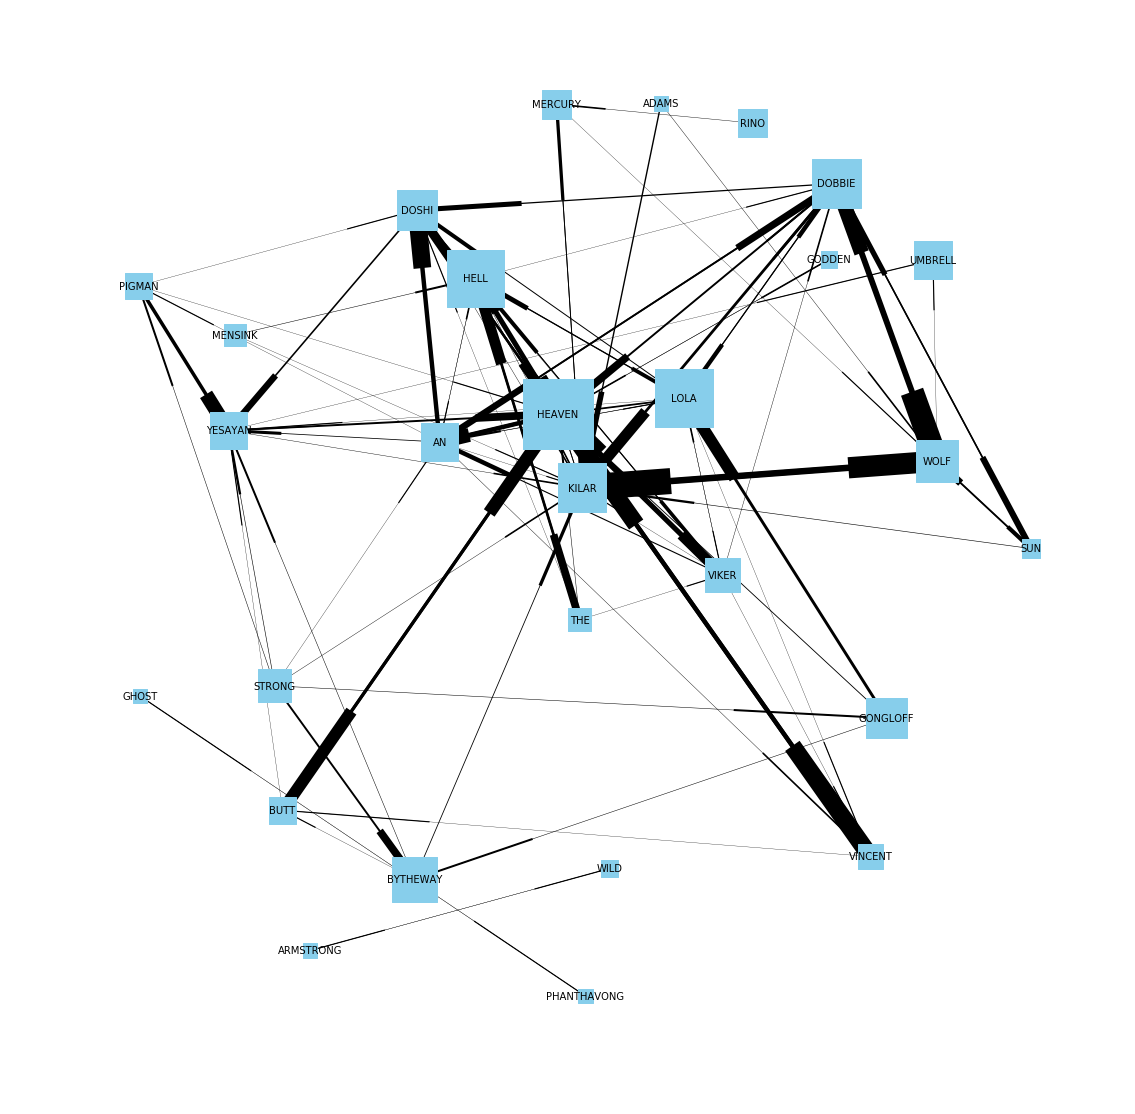

In [251]:
plt.figure(figsize=(15,15))
pos = nx.spring_layout(G2, k=0.8, iterations=20) ##make nodes further apart
nx.draw(G2, pos=pos, with_labels= True, node_color='skyblue', width=ew, node_shape='s', node_size=ns, font_size=10)

# plt.savefig('fam_directed.png',dpi = 100)

In [252]:
fam_dict['VINCENT']

9

In [108]:
G2.edges

EdgeView([('ADAMS', 'KILAR'), ('ADAMS', 'WOLF'), ('KILAR', 'AN'), ('KILAR', 'BYTHEWAY'), ('KILAR', 'DOBBIE'), ('KILAR', 'DOSHI'), ('KILAR', 'HEAVEN'), ('KILAR', 'HELL'), ('KILAR', 'KILAR'), ('KILAR', 'MENSINK'), ('KILAR', 'MERCURY'), ('KILAR', 'STRONG'), ('KILAR', 'SUN'), ('KILAR', 'VIKER'), ('KILAR', 'WOLF'), ('KILAR', 'YESAYAN'), ('WOLF', 'DOBBIE'), ('WOLF', 'MERCURY'), ('WOLF', 'SUN'), ('WOLF', 'UMBRELL'), ('WOLF', 'WOLF'), ('AN', 'AN'), ('AN', 'DOBBIE'), ('AN', 'DOSHI'), ('AN', 'HEAVEN'), ('AN', 'HELL'), ('AN', 'LOLA'), ('AN', 'PIGMAN'), ('AN', 'STRONG'), ('AN', 'VIKER'), ('AN', 'VINCENT'), ('AN', 'YESAYAN'), ('DOBBIE', 'DOBBIE'), ('DOBBIE', 'DOSHI'), ('DOBBIE', 'HEAVEN'), ('DOBBIE', 'HELL'), ('DOBBIE', 'LOLA'), ('DOBBIE', 'SUN'), ('DOBBIE', 'VIKER'), ('DOSHI', 'DOSHI'), ('DOSHI', 'HEAVEN'), ('DOSHI', 'HELL'), ('DOSHI', 'LOLA'), ('DOSHI', 'PIGMAN'), ('DOSHI', 'THE'), ('DOSHI', 'VIKER'), ('DOSHI', 'VINCENT'), ('DOSHI', 'YESAYAN'), ('HEAVEN', 'BUTT'), ('HEAVEN', 'GODDEN'), ('HEAVEN',

## Another Approach: look at object (not really working...)

In [103]:
def parse_obj(obj):
    return int(str_extract('[0-9]+(?=)', obj))

In [104]:
newdf = data.sort_values(by = 'time').reset_index(drop = True)
newdf['index'] = newdf.index
newdf['objID'] = newdf['obj'].apply(parse_obj)

In [296]:
newdf.query('(locX == "-2144") and (locY == "-362")')

,time,locX,locY,obj,playerID,index,objID
2695,197.68,-2144,-362,0,2540891,2695,0
9552,530.36,-2144,-362,292,2540891,9552,292
9638,537.32,-2144,-362,0,2540891,9638,0
10998,635.89,-2144,-362,314,2540891,10998,314
12573,770.02,-2144,-362,0,2540891,12573,0
13613,855.97,-2144,-362,69,2540891,13613,69
16253,1070.47,-2144,-362,441,2540891,16253,441
27474,1689.50,-2144,-362,0,2540963,27474,0
27492,1690.83,-2144,-362,441,2540963,27492,441
27940,1723.73,-2144,-362,0,-1,27940,0


In [295]:
newdf.query('(obj == "441")')

,time,locX,locY,obj,playerID,index,objID
16253,1070.47,-2144,-362,441,2540891,16253,441
27492,1690.83,-2144,-362,441,2540963,27492,441
28007,1727.12,-2144,-362,441,2541048,28007,441
28145,1735.99,-2143,-360,441,2541048,28145,441
28300,1745.87,-2143,-360,441,2541048,28300,441
35426,1851.69,-877,86,441,2541006,35426,441
36772,1929.77,-1078,91,441,2541038,36772,441
40826,2010.59,-878,85,441,2541006,40826,441
41160,2033.88,-2143,-360,441,2541048,41160,441
43334,2161.04,-2144,-362,441,2541048,43334,441


In [290]:
newdf.query('playerID == "2540929"')

,time,locX,locY,obj,playerID,index,objID
2,0.03,-1876,662,59,2540929,2,59
86,6.11,-1888,672,67,2540929,86,67
102,7.03,-1888,672,69,2540929,102,69
129,9.76,-1888,672,107,2540929,129,107
143,10.41,-1888,672,34,2540929,143,34
168,12.42,-1884,673,107,2540929,168,107
300,23.57,-1886,651,45,2540929,300,45
347,26.35,-1891,657,66,2540929,347,66
375,28.16,-1888,658,30u4,2540929,375,30
398,29.33,-1888,658,30u3,2540929,398,30


In [188]:
newdf = newdf.iloc[0:50].copy()
item = '391u5'
player_list, idx = find_connection_through_item(item, 0)
player_list

['2963724']

In [183]:
idx.astype(int)

array([13, 40, 21, 26, 31, 34, 39, 45, 50])

In [176]:
newdf

,time,locX,locY,obj,playerID,index
0,0.00,-3910,119,0,2963621,0
1,0.01,-3909,121,0,2963721,1
3,0.09,-3695,-76,148,2963628,3
4,0.12,-4237,-599,0,2963651,4
5,0.17,-4289,-706,224,2963746,5
6,0.25,-4225,-603,0,2963640,6
7,0.70,-3921,123,0,2963702,7
8,0.73,-4233,-570,807,2963747,8
9,0.99,-3134,290,1109,2963732,9
10,1.06,-3917,115,235,2963724,10


In [189]:
newdf.query('playerID == "2963724"')

,time,locX,locY,obj,playerID,index
10,1.06,-3917,115,235,2963724,10
13,1.62,-3917,116,391u5,2963724,13
19,2.01,-3917,115,253u0,2963724,19
21,2.22,-3917,116,391u4,2963724,21
26,2.49,-3917,115,253u1,2963724,26
29,2.71,-3917,116,391u3,2963724,29
31,2.94,-3917,115,253u2,2963724,31
34,3.16,-3917,116,391u2,2963724,34
36,3.39,-3917,115,253u3,2963724,36
39,3.59,-3917,116,391u1,2963724,39


In [191]:
newdf.query('(locX == "-3917") and (locY == "115")')

,time,locX,locY,obj,playerID,index
10,1.06,-3917,115,235,2963724,10
19,2.01,-3917,115,253u0,2963724,19
26,2.49,-3917,115,253u1,2963724,26
31,2.94,-3917,115,253u2,2963724,31
36,3.39,-3917,115,253u3,2963724,36
45,3.84,-3917,115,253u4,2963724,45


In [123]:
len(newdf)

750912

In [124]:
newdf.head()

,time,locX,locY,obj,playerID,index
0,0.00,-3910,119,0,2963621,0
1,0.01,-3909,121,0,2963721,1
3,0.09,-3695,-76,148,2963628,3
4,0.12,-4237,-599,0,2963651,4
5,0.17,-4289,-706,224,2963746,5


In [181]:
def find_connection_through_item(item, k):
    obj_data = newdf.query('obj == @item')
    idx = []
    
    if not len(obj_data):
        return [],idx
    else:
        locX = obj_data.iloc[k]['locX']
        locY = obj_data.iloc[k]['locY']
        time = obj_data.iloc[k]['time']
        player_list = []
        keep_going = 1
        idx = np.append(idx, obj_data['index'])
        
        while keep_going:
            #find the player who interacted with this object
            identify_player = newdf.query('(locX == @locX) and (locY == @locY) and (time > @time)') 
            if not len(identify_player):
                break
            identify_player = identify_player.iloc[0]
            player = identify_player['playerID']
            t = identify_player['time']
            #add player to player_list
            player_list = np.append(player_list, player)
            #drop this row
            idxp = identify_player['index']
            idx = np.append(idx, idxp)
            
            #find where this player goes
            identify_location = newdf.query('(playerID == @player) and (time > @t)')
            if not len(identify_location):
                break
            identify_location = identify_location.iloc[0]
            locX = identify_location['locX']
            locY = identify_location['locY']
            time = identify_location['time']
            #drop this row
            idxl = identify_location['index']
            idx = np.append(idx, idxl)

        return list(set(player_list)), idx

In [137]:
connection_dict = {}
for item in [441,450,444]:
    item = str(item)
    player_list, idx = find_connection_through_item(item, 0)
    newdf = newdf.query('index not in @idx')
    connection_dict[item] = player_list

In [140]:
connection_dict

{'441': ['2964685',
  '2964572',
  '2964369',
  '2964533',
  '2964229',
  '2964778',
  '2964977',
  '2965896',
  '2963711',
  '2964451',
  '2964180',
  '2964291',
  '2963780',
  '2964102',
  '2964010',
  '2964983',
  '2964189',
  '2964975',
  '2964586',
  '2963924',
  '2964833',
  '2965769',
  '2964112'],
 '444': ['2963692',
  '2963651',
  '2963812',
  '2963754',
  '2963753',
  '2963864',
  '2963817'],
 '450': []}

In [98]:
newdf.query('obj == @item')

,time,locX,locY,obj,playerID,index
958,77.19,-4244,-600,444,2963651,958
2005,164.59,-3694,-72,444,2963742,2005
2063,168.40,-3693,-72,444,2963742,2063
2118,171.98,-3693,-72,444,2963742,2118
2165,175.42,-3694,-72,444,2963742,2165
5231,450.16,-4245,-600,444,2963692,5231
60613,2906.96,-4243,-600,444,2963768,60613
60783,2924.13,-4244,-600,444,2963768,60783
63556,3203.83,-4245,-600,444,2963936,63556
74547,3979.51,-4244,-600,444,2963936,74547


In [141]:
len(newdf)

750435